# Integration d'une conversation SMS/MMS dans une pièce de procédure

UFED Physical Analyser permet de retourver les conversations SMS et MMS, mais les capacités d'export proposées ne permettent pas une intégration facile et lisible de ces conversations dans une pièce de procédure. Le principa problème est la séparation des SMS et MMS en deux fichiers différents (avec chacun des images dans un fichier à part), et le manque de différenciation entre les deux interlocuteurs.

Les petits bouts de code ci dessous répondent à ce besoin en créant un tableau HTML, qu'il faudra ensuite convertir en ODT.

## Export des conversations

Le code suppose qu'on ne veut exporter les conversations qu'entre Alice et Bob, si Charlie vient se mêler à la conversation, il est possible d'adapter le code, mais là on part sur uniquement deux interlocuteurs.

Les conversations SMS et MMS sont à exporter en .xlsx avec UFED. 

## Variables d'entrée
Les fichiers ainsi créés sont renseignés dans les variables SMS_FILE et MMS_FILE.

MAXWIDTH est la largeur en pixel des images. 100, c'est bien pour une page A4, voire même un peu grand.

YOU_SUBSTR et ME_SUBSTR sont les noms des contacts, on peut replacer par les numéros, il faut regarder dans la colonne 'Correspondant' des fichiers .xlsx.

In [1]:
SMS_FILE = 'UfedSMSExport/Alicesms.xlsx'
MMS_FILE = 'UfedMMSExport/Alicemms.xlsx'
MAXWIDTH = 100
YOU_SUSBSTR = 'Alice'
ME_SUBSTR = 'Bob'

## Vif du sujet

In [2]:
from PIL import Image
import base64
from IPython.display import HTML
import pandas as pd
from os.path import basename
from io import BytesIO
import glob

def b64str_contents(fname, maxwidth=MAXWIDTH):
    '''Return a scaled and jpeg verson of the file as a base 64 encoded string'''
    try:
        img = Image.open(fname)
    except:
        print('Could not load '+fname)
        return ''
    s= img.size
    ratio = maxwidth/s[0]
    img.thumbnail((s[0]*ratio, s[1]*ratio), resample=Image.ANTIALIAS)
    buffer = BytesIO()
    img.save(buffer, format="JPEG")
    return base64.b64encode(buffer.getvalue()).decode('ascii')

def image_data_url(fname):
    '''Return the data URL embedding the given image'''
    answer='data:image/jpeg;base64,{contents}'
    return answer.format(contents=b64str_contents(fname))

from_me_to_you_template = '''<tr><td></td><td>{contents}</td></tr>'''
from_russia_with_love_template = '''<tr><td>{contents}</td><td></td></tr>'''
table_template = '''<table style="width:100%"><tr><td><b>{you}</b></td><td><b>{me}</b></td></tr>{rows}</table>'''

In [3]:
html_df = pd.DataFrame(columns=['datehour', 'html'])
def sms_to_html(row):
    template = from_me_to_you_template if row['Correspondant'][0] == 'À' else from_russia_with_love_template
    return template.format(contents=row['Message']).encode('utf8', 'ignore').decode('utf8')

sms_df = pd.read_excel(SMS_FILE, header=1)
sms_df['datehour'] = sms_df['Heure']
sms_df['html'] = sms_df.apply(sms_to_html, axis=1)
html_df = pd.concat([html_df, sms_df], join='inner')

In [4]:
fname_to_fullpath = {basename(fname):fname for fname in glob.glob('**/*.[jpg][pni][gf]', recursive=True)}  # If two 
# files have the same basename, there is a bug hidden in there
# The [jpg][pni][gf] abomination will match jpg, png and gif
# It will also match ppe, gng and pif, but that's an unfortunate side effect.

In [5]:
mms_df = pd.read_excel(MMS_FILE, header=1)
mms_df['datehour'] = mms_df['Heure']
def mms_to_html(row):
    template = from_me_to_you_template if ME_SUBSTR in row['De'] else from_russia_with_love_template
    image_files = [fname for fname in row[['Pièce jointe #1', 'Pièce jointe #2', 'Pièce jointe #3']] if 
                  type(fname) == str and fname[-3:] in 'jpgpngpeggif']
    img_template = '<img src="{url}"/>'
    return template.format(contents='\n'.join([img_template.format(url=image_data_url(fname_to_fullpath[fname])) for 
                                              fname in image_files]))
mms_df['html'] = mms_df.apply(mms_to_html, axis=1)
html_df = pd.concat([html_df, mms_df], join='inner')

In [6]:
html_df.sort_values(by='datehour', inplace=True)
html = table_template.format(you='Bob', me='Alice',
                           rows='\n'.join(html_df['html']))

## HTML and ODT  Export

La variable `html` contient le tableau, que l'on peut sauver dans un fichier ou afficher directement

Bob,Alice
,Hi Bob !
Hi Alice !,
,This software sure looks awesome.
,
It sure does.,
,"What a wonderful imaginary life we live ! No more Diffie Hellman, key exchanges or convuluted scenarios with Eve to sociopath, just cute pictures of small animals."
,

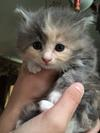
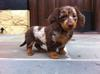

In [7]:
HTML(html)

In [8]:
open('Dialogue.html', 'w').write(html)

8597

Il faut ensuite convertir ce ficher en ODT, par exemple avec pandoc :

    pandoc -f html -t odt < Dialogue.html  -o Dialogue.odt
    
L'ouverture directe de ce fichier dans LibreOffice, ou un copier-coller ne fonctionnent pas chez moi.